# The New York Social Graph


[New York Social Diary](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/) provides a
fascinating lens onto New York's socially well-to-do.  The data forms a natural [social graph](https://en.wikipedia.org/wiki/Social_graph) for New York's social elite.  Take a look at this page of a recent [run-of-the-mill holiday party](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2014/holiday-dinners-and-doers). Please note that these links point to the internet archive, as the original website has recently removed most of its archives. Many of the images no longer load, but all the HTML is still there.

Besides the brand-name celebrities, you will notice the photos have carefully annotated captions labeling those that appear in the photos.  We can think of this as implicitly implying a social graph: there is a connection between two individuals if they appear in a picture together.

For this project, we will assemble the social graph from photo captions for parties dated December 1, 2014, and before.  Using this graph, we can make guesses at the most popular socialites, the most influential people, and the most tightly coupled pairs.

We will attack the project in three phases:
1. Get a list of all the photo pages to be analyzed.
2. Parse all of the captions on a sample page.
3. Parse all of the captions on all pages, and assemble the graph.

## Phase One


The first step is to crawl the data.  We want photos from parties on or before December 1st, 2014.  Go to the [Party Pictures Archive](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures) to see a list of (party) pages.  We want to get the url for each party page, along with its date.

Here are some packages that you may find useful.  You are welcome to use others, if you prefer.

In [3]:
import requests
import dill
from bs4 import BeautifulSoup
from datetime import datetime

We recommend using Python [Requests](http://docs.python-requests.org/en/master/) to download the HTML pages, and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) to process the HTML.  Let's start by getting the [first page](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures).

In [4]:
# Use requests.get to download the page.

page_url = "https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures"

page_response = requests.get(page_url)

resp_code = page_response.status_code
resp_reason = page_response.reason

print('| STATUS | ' + str(resp_code) + ' | ' + str(resp_reason) + '\n')

if resp_code == 200:
    print(page_response.url+'\n')
    print(page_response.text[:1000] + " ... ") # print first 1000 char of html page code
else:
    print('Page DID NOT load properly! NYSD Archive Page is temporarily misbehaving.')

| STATUS | 200 | OK

https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures

<!DOCTYPE html>
  <!--[if IEMobile 7]><html class="no-js ie iem7" lang="en" dir="ltr"><![endif]-->
  <!--[if lte IE 6]><html class="no-js ie lt-ie9 lt-ie8 lt-ie7" lang="en" dir="ltr"><![endif]-->
  <!--[if (IE 7)&(!IEMobile)]><html class="no-js ie lt-ie9 lt-ie8" lang="en" dir="ltr"><![endif]-->
  <!--[if IE 8]><html class="no-js ie lt-ie9" lang="en" dir="ltr"><![endif]-->
  <!--[if (gte IE 9)|(gt IEMobile 7)]><html class="no-js ie" lang="en" dir="ltr" prefix="fb: http://ogp.me/ns/fb# og: http://ogp.me/ns# article: http://ogp.me/ns/article# book: http://ogp.me/ns/book# profile: http://ogp.me/ns/profile# video: http://ogp.me/ns/video# product: http://ogp.me/ns/product#"><![endif]-->
  <!--[if !IE]><!--><html class="no-js" lang="en" dir="ltr" prefix="fb: http://ogp.me/ns/fb# og: http://ogp.me/ns# article: http://ogp.me/ns/article# book: http://ogp.me/ns/book# profile: http://o

Now, we process the text of the page with BeautifulSoup.

In [5]:
soup = BeautifulSoup(page_response.text, "lxml")
print(soup.prettify())

<!DOCTYPE html>
<!--[if IEMobile 7]><html class="no-js ie iem7" lang="en" dir="ltr"><![endif]-->
<!--[if lte IE 6]><html class="no-js ie lt-ie9 lt-ie8 lt-ie7" lang="en" dir="ltr"><![endif]-->
<!--[if (IE 7)&(!IEMobile)]><html class="no-js ie lt-ie9 lt-ie8" lang="en" dir="ltr"><![endif]-->
<!--[if IE 8]><html class="no-js ie lt-ie9" lang="en" dir="ltr"><![endif]-->
<!--[if (gte IE 9)|(gt IEMobile 7)]><html class="no-js ie" lang="en" dir="ltr" prefix="fb: http://ogp.me/ns/fb# og: http://ogp.me/ns# article: http://ogp.me/ns/article# book: http://ogp.me/ns/book# profile: http://ogp.me/ns/profile# video: http://ogp.me/ns/video# product: http://ogp.me/ns/product#"><![endif]-->
<!--[if !IE]><!-->
<html class="no-js" dir="ltr" lang="en" prefix="fb: http://ogp.me/ns/fb# og: http://ogp.me/ns# article: http://ogp.me/ns/article# book: http://ogp.me/ns/book# profile: http://ogp.me/ns/profile# video: http://ogp.me/ns/video# product: http://ogp.me/ns/product#">
 <!--<![endif]-->
 <head>
  <script src

This page has links to 50 party pages. Look at the structure of the page and determine how to isolate those links.  Your browser's developer tools (usually `Cmd`-`Option`-`I` on Mac, `Ctrl`-`Shift`-`I` on others) offer helpful tools to explore the structure of the HTML page.

Once you have found a pattern, use BeautifulSoup's [select](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#css-selectors) or [find_all](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#find) methods to get those elements.

In [6]:
links = soup.find_all('div', attrs={'class':'views-row'})
print(len(links))

50


There should be 50 per page.

In [7]:
grader.check(len(links) == 50)

True

Let's take a look at that first link.  Figure out how to extract the URL of the link, as well as the date.  You probably want to use `datetime.strptime`.  See the [format codes for dates](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) for reference.

In [8]:
# Check that the title and date match what you see visually.
link = links[0]
print(link)

<div class="views-row views-row-1 views-row-odd views-row-first">
<span class="views-field views-field-title"> <span class="field-content"><a href="/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/kicks-offs-sing-offs-and-pro-ams">Kicks offs, sing offs, and pro ams</a></span> </span>
<span class="views-field views-field-created"> <span class="field-content">Friday, September 11, 2015</span> </span> </div>


For purposes of code reuse, let's put that logic into a function.  It should take the link element and return the URL and date parsed from it.

In [9]:
def get_link_date(el):
    url = 'https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com' + el.a['href']
    date_span = el.select('span.field-content')[1].text
    date = datetime.strptime(date_span.strip(),'%A, %B %d, %Y')
    return url, date

In [10]:
get_link_date(link)

('https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/kicks-offs-sing-offs-and-pro-ams',
 datetime.datetime(2015, 9, 11, 0, 0))

You may want to check that it works as you expected (see above output).

Once that's working, let's write another function to parse all of the links on a page.  Thinking ahead, we can make it take a Requests [Response](https://requests.readthedocs.io/en/master/api/#requests.Response) object and do the BeautifulSoup parsing within it.

In [11]:
def get_links(page_response):
    soup = BeautifulSoup(page_response.text, 'lxml')
    temp_list = soup.find_all('div', attrs={'class':'views-row'})
    link_pairs = []
    for el in temp_list:
        pair = get_link_date(el)
        link_pairs.append(pair)
    return link_pairs # A list of URL, date pairs

In [12]:
print(get_links(page_response)[:10])

[('https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/kicks-offs-sing-offs-and-pro-ams', datetime.datetime(2015, 9, 11, 0, 0)), ('https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/grand-finale-of-the-hampton-classic-horse-show', datetime.datetime(2015, 9, 1, 0, 0)), ('https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/riders-spectators-horses-and-more', datetime.datetime(2015, 8, 26, 0, 0)), ('https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/artist-and-writers-and-designers', datetime.datetime(2015, 8, 20, 0, 0)), ('https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/we

If we run this on the previous response, we should get 50 pairs.

In [13]:
# These should be the same links from earlier
grader.check(len(get_links(page_response)) == 50)

True

But we only want parties with dates on or before the first of December, 2014.  Let's write a function to filter our list of dates to those at or before a cutoff.  Using a keyword argument, we can put in a default cutoff, but allow us to test with others.

In [14]:
def filter_by_date(links, cutoff=datetime(2014, 12, 1)):
    # Return only the elements with date <= cutoff
    filtered_link_pairs = []
    for el in links:
        if el[1] <= cutoff:
            filtered_link_pairs.append(el)
    return filtered_link_pairs

With the default cutoff, there should be no valid parties on the first page.  Adjust the cutoff date to check that it is actually working.

In [15]:
# Double check the dates are being extracted correctly
grader.check(len(filter_by_date(get_links(page_response))) == 0)

True

Now we should be ready to get all of the party URLs.  Click through a few of the index pages to determine how the URL changes.  Figure out a strategy to visit all of them.

HTTP requests are generally IO-bound.  This means that most of the time is spent waiting for the remote server to respond.  If you use `requests` directly, you can only wait on one response at a time.  [requests-futures](https://github.com/ross/requests-futures) lets you wait for multiple requests at a time.  You may wish to use this to speed up the downloading process.

In the end, you should have 1193 parties.

In case we need to restart the notebook, we should save this information to a file.  There are many ways you could do this; here's one using `dill`.

To restore the list, we can just load it from the file.  When the notebook is restarted, you can skip the code above and just run this command.

## Question 1: histogram


Get the number of party pages for the 95 months (that is, month-year pair) in the data.  Represent this histogram as a list of 95 tuples, each of the form `("Dec-2014", 1)`.  Note that you can convert `datetime` objects into these sort of strings with `strftime` and the [format codes for dates](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior).

Plot the histogram for yourself.  Do you see any trends?

In [22]:
party_dates = []
formatted_party_dates = []

for i in filtered_links_list:
    party_dates.append(i[1])

print(party_dates[:5])

for j in party_dates:
    formatted_party_dates.append(j.strftime('%b-%y'))

print(formatted_party_dates[:5])

if len(party_dates) == len(formatted_party_dates):
    print(f"Length of both party & formatted MMM-YY dates = {len(party_dates)}")
else:
    print("Something may be wrong! Investigate")

[datetime.datetime(2014, 12, 1, 0, 0), datetime.datetime(2014, 11, 24, 0, 0), datetime.datetime(2014, 11, 20, 0, 0), datetime.datetime(2014, 11, 18, 0, 0), datetime.datetime(2014, 11, 17, 0, 0)]
['Dec-14', 'Nov-14', 'Nov-14', 'Nov-14', 'Nov-14']
Length of both party & formatted MMM-YY dates = 1193


In [23]:
from collections import Counter

histogram = list(Counter(formatted_party_dates).items())
print(histogram[:10])

[('Dec-14', 1), ('Nov-14', 10), ('Oct-14', 9), ('Sep-14', 5), ('Aug-14', 6), ('Jul-14', 10), ('Jun-14', 10), ('May-14', 12), ('Apr-14', 8), ('Mar-14', 11)]


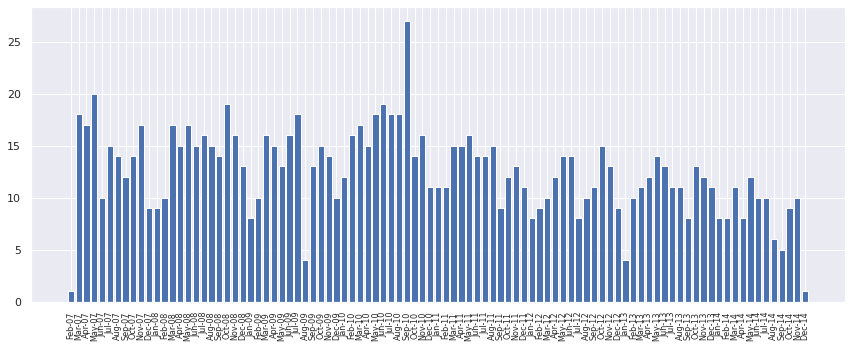

In [24]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 5]
plt.rcParams["figure.autolayout"] = True

date_indx = []
count_freq = []

def sorting_by_date(record):
    return datetime.strptime(record[0], '%b-%y')

histogram_sorted = sorted(histogram, key=sorting_by_date)

for el in histogram_sorted:
    date_indx.append(el[0])
    count_freq.append(el[1])

plt.bar(date_indx, count_freq)
plt.xticks(rotation=90, fontsize = 8)
plt.show()

In [ ]:
# histogram = [("Dec-2014", 1)] * 95  # Replace this fake answer with your real results

In [25]:
grader.score('graph__histogram', histogram)

Your score: 1.0000


## Phase Two


In this phase, we concentrate on getting the names out of captions for a given page.  We'll start with [the benefit cocktails and dinner](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood) for [Lenox Hill Neighborhood House](http://www.lenoxhill.org/), a neighborhood organization for the East Side.

Take a look at that page.  Note that some of the text on the page is captions, but others are descriptions of the event.  Determine how to select only the captions.

By our count, there are about 110.  But if you're off by a couple, you're probably okay.

Let's encapsulate this in a function.  As with the links pages, we want to avoid downloading a given page the next time we need to run the notebook.  While we could save the files by hand, as we did before, a checkpoint library like [ediblepickle](https://pypi.python.org/pypi/ediblepickle/1.1.3) can handle this for you.  (Note, though, that you may not want to enable this until you are sure that your function is working.)

You should also keep in mind that HTTP requests fail occasionally, for transient reasons.  You should plan how to detect and react to these failures.   The [retrying module](https://pypi.python.org/pypi/retrying) is one way to deal with this.

This should get the same captions as before.

Now that we have some sample captions, let's start parsing names out of those captions.  There are many ways of going about this, and we leave the details up to you.  Some issues to consider:

  1. Some captions are not useful: they contain long narrative texts that explain the event.  Try to find some heuristic rules to separate captions that are a list of names from those that are not.  A few heuristics include:
    - Look for sentences (which have verbs) and as opposed to lists of nouns. For example, [`nltk` does part of speech tagging](http://www.nltk.org/book/ch05.html) but it is a little slow. There may also be heuristics that accomplish the same thing.
    - Similarly, spaCy's [entity recognition](https://spacy.io/docs/usage/entity-recognition) could be useful here, but like `nltk` using `spaCy` will add to processing time.
    - Look for commonly repeated threads (e.g. you might end up picking up the photo credits or people such as "a friend").
    - Long captions are often not lists of people.  The cutoff is subjective, but for grading purposes *we set that cutoff at 250 characters*.
  2. You will want to separate the captions based on various forms of punctuation.  Try using `re.split`, which is more sophisticated than `string.split`. **Note**: The reference solution uses regex exclusively for name parsing.
  3. You might find a person named "ra Lebenthal".  There is no one by this name.  Can anyone spot what's happening here?
  4. This site is pretty formal and likes to say things like "Mayor Michael Bloomberg" after his election but "Michael Bloomberg" before his election.  Can you find other ('optional') titles that are being used?  They should probably be filtered out because they ultimately refer to the same person: "Michael Bloomberg."
  5. There is a special case you might find where couples are written as e.g. "John and Mary Smith". You will need to write some extra logic to make sure this properly parses to two names: "John Smith" and "Mary Smith".
  6. When parsing names from captions, it can help to look at your output frequently and address the problems that you see coming up, iterating until you have a list that looks reasonable. This is the approach used in the reference solution. Because we can only asymptotically approach perfect identification and entity matching, we have to stop somewhere.
  
**Questions worth considering:**
  1. Who is Patrick McMullan and should he be included in the results? How would you address this?
  2. What else could you do to improve the quality of the graph's information?

## Question 2: sample_names


Once you feel that your algorithm is working well on these captions, parse all of the captions and extract all the names mentioned.  Sort them alphabetically, by first name, and return the first hundred.

In [34]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [35]:
def spacy_parse_string(party_string):
    doc = nlp(party_string)
    
    list_of_names = [ent.text for ent in doc.ents if ent.label_=='PERSON']
    
    for ind in range(len(list_of_names)-2,-1,-1):
        if len(list_of_names[ind].split(" ")) == 1 and len(list_of_names[ind+1].split(" ")) !=1:
            list_of_names[ind] = list_of_names[ind] +  " " + list_of_names[ind+1].split(" ")[1]
    
    return list_of_names

In [36]:
names = [s for s in captions_list]

n = []

for name in names:
    n.append(spacy_parse_string(name))

print(len(n))
print(type(n))
n[:10]

110
<class 'list'>


[['Glenn Adamson',
  'Simon Doonan',
  'Victoire de Castellane',
  'Craig Leavitt',
  'Jerome Chazen',
  'Andi Potamkin',
  'Ralph Pucci',
  'Kirsten Bailey',
  'Edwin Hathaway',
  'Dennis Freedman'],
 [],
 ['Christopher Spitzmiller'],
 ['Christopher Spitzmiller', 'Diana Quasha'],
 ['Mariam Azarm', 'Sana Sabbagh', 'Lynette Dallas'],
 ['Christopher Spitzmiller', 'Sydney Shuman', 'Matthew Bees'],
 ['Christopher Spitzmiller', 'Tom Edelman'],
 ['Sydney Shuman'],
 ['Sean McAndrew'],
 ['Sydney Shuman', 'Mario Buatta', 'Helene Tilney']]

In [37]:
sample_names = []

for i in range(len(n)):
    for j in n[i]:
        sample_names.append(j)

print(len(sample_names))
print(type(sample_names))
sample_names[:20]

185
<class 'list'>


['Glenn Adamson',
 'Simon Doonan',
 'Victoire de Castellane',
 'Craig Leavitt',
 'Jerome Chazen',
 'Andi Potamkin',
 'Ralph Pucci',
 'Kirsten Bailey',
 'Edwin Hathaway',
 'Dennis Freedman',
 'Christopher Spitzmiller',
 'Christopher Spitzmiller',
 'Diana Quasha',
 'Mariam Azarm',
 'Sana Sabbagh',
 'Lynette Dallas',
 'Christopher Spitzmiller',
 'Sydney Shuman',
 'Matthew Bees',
 'Christopher Spitzmiller']

In [38]:
import numpy as np

sample_names_sorted =np.sort(sample_names)
sample_names_sorted = np.unique(sample_names_sorted)
sample_names_sorted_100 = sample_names_sorted[0:100]
print(type(sample_names_sorted_100))

# converting to list
sample_names_sorted_100_list = sample_names_sorted_100.tolist()
print(type(sample_names_sorted_100_list))
print(sample_names_sorted_100_list [:20])

<class 'numpy.ndarray'>
<class 'list'>
['Alberto Villalobos', 'Alex Papachristidis', 'Alexandra Richards', 'Alexis Mersentes', 'Allen Swerdlick', 'Allison Minton', 'Andi Potamkin', 'Angela Clofine', 'Anne Strickland', 'Barbara  ', 'Barbara Regna', 'Barbara Tober', 'Ben Needell Esq', 'Bette Midler', 'Bjorn Wallander', 'C. Virginia Fields', 'Celia Morrissette', 'Chele Farley', 'Christopher Spitzmiller', 'Clark Munnell']


In [39]:
print(len(sample_names_sorted_100_list))
print(type(sample_names_sorted_100_list))

100
<class 'list'>


In [40]:
# sample_names = ["Caroline Dean"] * 100

grader.score('graph__sample_names', sample_names_sorted_100_list)

Your score: 0.9700


Now, run this sort of test on a few other pages.  You will probably find that other pages have a slightly different HTML structure, as well as new captions that trip up your caption parser.  But don't worry if the parser isn't perfect -- just try to get the easy cases.

## Phase Three


Once you are satisfied that your caption scraper and parser are working, run this for all of the pages.  If you haven't implemented some caching of the captions, you probably want to do this first.

For the remaining analysis, we think of the problem in terms of a
[network](http://en.wikipedia.org/wiki/Computer_network) or a
[graph](https://en.wikipedia.org/wiki/Graph_%28discrete_mathematics%29).  Any time a pair of people appear in a photo together, that is considered a link.  What we have described is more appropriately called an (undirected)
[multigraph](http://en.wikipedia.org/wiki/Multigraph) with no self-loops, but this has an obvious analog in terms of an undirected [weighted graph](http://en.wikipedia.org/wiki/Graph_%28mathematics%29#Weighted_graph).  

In the remainder of this miniproject, we will analyze the social graph of the New York social elite.  We recommend using python's [`networkx`](https://networkx.github.io/) library to build this social graph.

All in all, you should end up with over 100,000 captions and more than 110,000 names, connected in about 200,000 pairs.

**Note:** If you have a significantly smaller number of names or name pairs, verify that you are correctly identifying the caption(s) from each party page.  Are there some pages where your methods return no names?  Examine those pages more closely to determine why that is the case and modify your methods appropriately.  

## Question 3: degree


...

## Question 4: PageRank


...

## Question 5: best_friends


...

*Copyright &copy; 2022 Pragmatic Institute. This content is licensed solely for personal use. Redistribution or publication of this material in whole is strictly prohibited.*